<a href="https://colab.research.google.com/github/tiagorochadealmeida/Caixa/blob/master/Copy_of_primeiro_classificador_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primeiro classificador usando Tensorflow e Keras

## Funcionamento de um modelo pré-treinado
Conceitualmente, podemos usar qualquer modelo pré-treinado em algum conjunto de imagens, e que apresenta alguma arquitetura, para reconhecer/classificar uma imagem nova que esteja dentro das categorias de imagens para as quais o modelo foi treinado.

Tomando como base o modelo Resnet50, treinado na ImageNet e disponível na biblioteca Keras, podemos instanciar esse modelo e submeter a ele uma nova imagem de alguma das 1.000 categorias da ImageNet e o modelo tem que ser capaz de prever, com certo grau de precisão, a classe a qual aquela imagem pertence.

Iremos instanciar o modelo Resnet50 e submeter 2 imagens: um avião e um tigre. Essas imagens podem ser obtidas diretamente da internet.

In [0]:
# Importando as bibliotecas e o modelo escolhido
# Precisamos garantir que as funções importing preprocess_input e decode_predictions
# estão sendo importadas do modelo resnet50
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

Using TensorFlow backend.


In [0]:
# Para visualizar a imagem
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
# Baixando o modelo Resnet50 pré-treinado na ImageNet
pre_train = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
102858752/102853048 [==============================] - 1s 0us/step


In [0]:
# Exibindo as camadas da rede
pre_train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
# Para baixar a imagem da internet
from urllib.request import urlopen

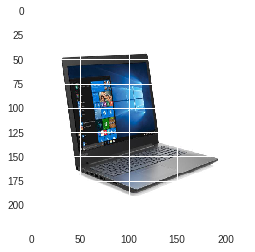

In [0]:
# Seguindo o link da primeira imagem obtida na pesquisa do Google para 'notebook'
link = urlopen('https://i.zst.com.br/images/notebook-lenovo-ideapad-300-intel-celeron-n4000-4gb-de-ram-hd-1-tb-15-6-windows-10-ideapad-330-photo565030432-12-35-d.jpg')

# carregando e redimensionando a imagem no tamanho padrão da ImageNet
imagem = image.load_img(link, target_size=(224,224))

# exibindo a imagem
plt.imshow(imagem)

In [0]:
# Pré-processamento da imagem para submeter ao modelo

# Primeiro convertemos a imagem em array
entrada = image.img_to_array(imagem)
# depois transformamos a imagem em um array de uma única linha
entrada = np.expand_dims(entrada, axis=0)
# e por fim submetemos a funcão de pré-processamento da arquitetura Resnet50
entrada = preprocess_input(entrada)

# Submetendo a entrada ao modelo para obter as previsões
previsao = pre_train.predict(entrada)

# Usando a função decode_predictions para decodificar o resultado
# mostrando as 4 classes mais prováveis para a imagem de entrada
print('Previsões: ', decode_predictions(previsao, top=4)[0])

40960/35363 [==================================] - 0s 1us/step
Previsões:  [('n03832673', 'notebook', 0.8028425), ('n03642806', 'laptop', 0.094334036), ('n03180011', 'desktop_computer', 0.03733231), ('n06359193', 'web_site', 0.012191589)]


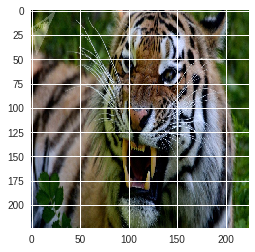

In [0]:
# Seguindo o link da primeira imagem obtida na pesquisa do Google para 'tigre'
link = urlopen('https://cdnbr2.img.sputniknews.com/images/977/42/9774299.jpg')

# carregando e redimensionando a imagem no tamanho padrão da ImageNet
imagem = image.load_img(link, target_size=(224,224))

# exibindo a imagem
plt.imshow(imagem)

In [0]:
# Pré-processamento da imagem para submeter ao modelo

# Primeiro convertemos a imagem em array
entrada = image.img_to_array(imagem)
# depois transformamos a imagem em um array de uma única linha
entrada = np.expand_dims(entrada, axis=0)
# e por fim submetemos a funcão de pré-processamento da arquitetura Resnet50
entrada = preprocess_input(entrada)

# Submetendo a entrada ao modelo para obter as previsões
previsao = pre_train.predict(entrada)

# Usando a função decode_predictions para decodificar o resultado
# mostrando as 4 classes mais prováveis para a imagem de entrada
print('Previsões: ', decode_predictions(previsao, top=4)[0])

Previsões:  [('n02129604', 'tiger', 0.6797949), ('n02123159', 'tiger_cat', 0.32018155), ('n02127052', 'lynx', 1.0257651e-05), ('n02391049', 'zebra', 6.3928846e-06)]


## Transfer Learning
É possível adaptar um modelo pré-treinado, independente da quantidade de classes nas quais ele foi treinado, para classificar uma nova quantidade de classes. Isso pode ser feito mesmo que o modelo pré-treinado não tenha sido treinado nas novas classes de imagem a serem classificadas agora. E mesmo que a nova quantidade de classes de imagens a serem identificadas agora seja diferente da quantidade de classes do treinamento original.

O modelos de redes neurais convolucionais (CNNs) são formados por diversas camadas (layers) e cada uma dessas camadas tem a responsabilidade de identificar algum tipo de padrão nas imagens (borda, fundo etcs). Em geral, a última dessas camadas faz, efetivamente, a definição de qual a classe da imagem.

O processo de transferência de conhecimento (transfer learning) consiste em usar quase todas as camadas pré-treinadas do modelo e substituir a última camada por uma nova camada, capaz de identificar as novas classes. Depois disso treinamos a nova rede mas mantendo intocados os pesos já definidos para as camadas iniciais.

## Usando Transfer Learning
Iremos usar o modelo ResNet50, já treinado com as imagens da ImageNet, para criarmos um novo modelo capaz de classificar imagens de gatos e cachorros. Vamos treinar uma nova rede, com diversas camadas baseadas na ResNet50 e a última camada alterada para identificar 2 classes, ao contrário das 1.000 classes do treinamento original.

### Configurando o modelo

In [0]:
# Inincialmente vamos baixar o dataset
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -qq cats_and_dogs_filtered.zip
!ls 'cats_and_dogs_filtered'

--2019-04-02 23:01:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   105MB/s    in 0.6s    

2019-04-02 23:01:50 (105 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

train  validation  vectorize.py


In [0]:
# Definindo os diretórios com as imagens
import os
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [0]:
# Vamos instanciar novamente o modelo Resnet50 pré-treinado na ImageNet
# mas agora sem a ultima camada. Esse será nosso modelo base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [0]:
# Exibindo as camadas da rede
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
# Precisamos garantir que os pesos definidos para as camadas iniciais do modelo
# não sejam alterados durante o treinamento que faremos
# Essas camadas iniciais serão congeladas (freezing)
for layer in base_model.layers:
  layer.trainable = False

In [0]:
# Agora precisamos criar a nova camada final do modelo

# Importando
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model

# Vamos pegar a saída do nosso modelo de base
x = base_model.output
# inserir as novas camadas
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# E criar o novo modelo com o modelo de base e nossas novas camadas
model = Model(base_model.input, predictions)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Vamos compilar o novo modelo incluindo um otimizador, um Learning Rate
# uma função de loss e a métrica do modelo

# Importando o otimizador
from keras.optimizers import Adam 

adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

### Configurando o carregamento das imagens

In [0]:
# Criando as estruturas para carregar e tratar as imagens
# de treino e validação

# Importando
from keras.preprocessing.image import ImageDataGenerator

# Definições
img_width, img_height = 224, 224
batch_size = 32
n_epochs = 10

# Train Image Augmentation
train_datagen = ImageDataGenerator(rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input)

# Imagens de treino
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size)

# Validation Image Augmentation
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Imagens de validação
validation_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Treinando o modelo

In [0]:
# Treinando o modelo
model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.n // batch_size,
    epochs = n_epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
62/62 [==============================] - 45s 719ms/step - loss: 0.3932 - acc: 0.8115 - val_loss: 0.1002 - val_acc: 0.9677
Epoch 2/10
62/62 [==============================] - 38s 614ms/step - loss: 0.1717 - acc: 0.9355 - val_loss: 0.0563 - val_acc: 0.9804
Epoch 3/10
62/62 [==============================] - 38s 608ms/step - loss: 0.1454 - acc: 0.9466 - val_loss: 0.0445 - val_acc: 0.9824
Epoch 4/10
62/62 [==============================] - 38s 612ms/step - loss: 0.1183 - acc: 0.9567 - val_loss: 0.0375 - val_acc: 0.9835
Epoch 5/10
62/62 [==============================] - 38s 616ms/step - loss: 0.1165 - acc: 0.9511 - val_loss: 0.0341 - val_acc: 0.9855
Epoch 6/10
62/62 [==============================] - 38s 612ms/step - loss: 0.0992 - acc: 0.9637 - val_loss: 0.0465 - val_acc: 0.9814
Epoch 7/10
62/62 [==============================] - 39s 628ms/step - loss: 0.0875 - acc: 0.9688 - val_loss: 0.0327 - val_acc: 0.9897
Epoch 8/10
62/62 [===

### Validando o modelo treinado

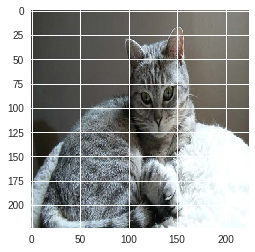

In [0]:
# Seguindo o link de uma imagem obtida na pesquisa do Google para 'gato'
link = urlopen('https://www.tiendanimal.pt/blog/wp-content/uploads/2016/02/como-ensinar-um-gato-a-usar-a-sanita.jpg')

# carregando e redimensionando a imagem no tamanho padrão da ImageNet
imagem = image.load_img(link, target_size=(224,224))

# exibindo a imagem
plt.imshow(imagem)

In [0]:
# Pré-processamento da imagem para submeter ao modelo

# Primeiro convertemos a imagem em array
entrada = image.img_to_array(imagem)
# depois transformamos a imagem em um array de uma única linha
entrada = np.expand_dims(entrada, axis=0)
# e por fim submetemos a funcão de pré-processamento da arquitetura Resnet50
entrada = preprocess_input(entrada)

# Submetendo a entrada ao modelo para obter as previsões
previsao = model.predict(entrada)

# Usando a função decode_predictions para decodificar o resultado
# mostrando as 2 classes com suas probabilidades
print('Previsão: ', previsao) 

Previsão:  [[9.9996448e-01 3.5491033e-05]]


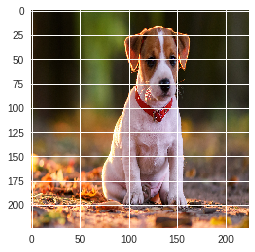

In [0]:
# Seguindo o link de uma imagem obtida na pesquisa do Google para 'cachorro'
link = urlopen('https://abrilsuperinteressante.files.wordpress.com/2018/05/filhotes-de-cachorro-alcanc3a7am-o-c3a1pice-de-fofura-com-8-semanas1.png')

# carregando e redimensionando a imagem no tamanho padrão da ImageNet
imagem = image.load_img(link, target_size=(224,224))

# exibindo a imagem
plt.imshow(imagem)

In [0]:
# Pré-processamento da imagem para submeter ao modelo

# Primeiro convertemos a imagem em array
entrada = image.img_to_array(imagem)
# depois transformamos a imagem em um array de uma única linha
entrada = np.expand_dims(entrada, axis=0)
# e por fim submetemos a funcão de pré-processamento da arquitetura Resnet50
entrada = preprocess_input(entrada)

# Submetendo a entrada ao modelo para obter as previsões
previsao = model.predict(entrada)

# Usando a função decode_predictions para decodificar o resultado
# mostrando as 2 classes com suas probabilidades
print('Previsão: ', previsao)

Previsão:  [[8.773362e-06 9.999912e-01]]
